Populating the interactive namespace from numpy and matplotlib
del_eps: 3.0 v_slab: -0.8
r0: [ 0.] r1: [ 62.83185307]
r_T_1d: [ 43.98229715] r_R_1d: [ 18.84798513]
simulation time: 1:16


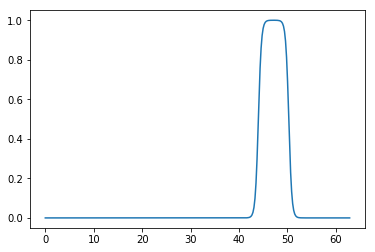

In [1]:
%pylab inline

from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'moving-slab')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)


n_dim = 1
r0, r1, dr = [None]*3
S = 0.9
n_t = None
save_every = 10
source_at_right = False

r_c = None
r0_eps, r1_eps = None, None
r0_deps, r1_deps = None, None
a_eps, b_eps = None, None
omega = 1.0 #2.0*np.pi
s_pml = None
d_pml = None
set_pml = True
is_t_var = True

n = 1.0
del_n = 1.0
del_eps = (n+del_n)**2 - n**2

L_0_air = 2.0*np.pi/(omega)
L_0 = 2.0*np.pi/(omega*n)


if n_dim==1:
    r0 = np.array([0.0])
    r1 = np.array([10.0*L_0])
    dr = np.array([L_0/2000])
    S /= np.sqrt(1)
    n_t = 12000

    r_c = (r0+r1)/2.0
    a_eps, b_eps = n**2, 1.0
    w_eps = (r1-r0)/2
    r0_eps = r_c - w_eps/2.0
    r1_eps = r_c + w_eps/2.0
    
    W_slab = r1 - r0 - np.array([2.0*L_0])
    r0_deps = r_c - W_slab/2
    r1_deps = r_c + W_slab/2

    d_pml = np.array([2.0*L_0])
    s_pml = np.array([1.0+2.5j/L_0])
else:
    assert False
    
dt = S*dr[0]*np.sqrt(min(a_eps+del_eps, b_eps))
d_v = np.prod(dr)


fdtd = FDTDSimulator()

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

d_x_ = np.zeros(n_dim)
d_x_[0] = (r1[0]-r0[0])
d_x_pml = np.zeros(n_dim)
d_x_pml[0] = d_pml[0]


##----- sources

T_per = 2.0*np.pi/omega
T_0 = 0.01*T_per
t0 = 3.0*T_0
f_t = lambda t: -1.0*np.exp(-(t-t0)**2/T_0**2)#*np.sin(2.0*omega*(t-t0))
f_t_dt = lambda t: f_t(t-dt/2)

## J
r_j = r0 + d_pml + 2*L_0_air
r_j -= r_j - int(r_j/dr[0])*dr[0]
je_mag = 1.0/dr[0]
src_dir = 'z'
je_type = FVTypes.JePoint
je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

## M
r_m = r_j - dr[0]/2      
jm_mag = -1.0/dr[0]
src_dir = 'y'
jm_type = FVTypes.JmPoint
jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':b_eps}
fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

##---- slab
d_slab = 2.0*L_0_air/(n+del_n)
x_rise_slab = 0.1*L_0_air
r0_slab = r1[0] - d_pml[0] - L_0_air
v_slab = -0.8

f_dslab = lambda x: 0.5*(np.tanh(x/x_rise_slab) - np.tanh((x-d_slab)/x_rise_slab))
                     
_x = np.linspace(r0[0], r1[0], 300)
plot(_x, f_dslab(_x-r0_slab))
                     
deps = None
f_deps = None
deps_out = []
if is_t_var:
    print('del_eps:', del_eps, 'v_slab:', v_slab)
    a_deps = None
    if n_dim==1:
        a_deps = lambda r, t: del_eps*f_dslab((r-r0_slab) - v_slab*t)
    deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})
    
if set_pml:
    pml_args = {'d_pml':d_pml, 's_pml':s_pml}
    fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

set_Efields_entire_out = True
set_eps_out = False
set_j_out = False
set_T_1d = True
set_R_1d = True

r_R_1d = r_j - (r_j-d_pml)/2.0
r_T_1d = r1 - d_pml - L_0

print('r0:', r0, 'r1:', r1)
print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

if set_Efields_entire_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
if set_j_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
if n_dim==1 and set_T_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
if n_dim==1 and set_R_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})
        
if is_t_var and set_eps_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
    


In [2]:
import matplotlib.pyplot as plt

r_E, E_out_list = None, None
x_E, y_E, z_E = [None]*3
e_max = None
if set_Efields_entire_out:
    r_E, E_out_list = fdtd.GetOutputs('E')
    if n_dim==3:
        x_E, y_E, z_E = r_E
    elif n_dim==2:
        x_E, y_E = r_E
    elif n_dim==1:
        x_E = r_E[0]
    e_max = [np.max(np.abs(e)) for e in E_out_list]
    print('max(e_max):', max(e_max))
    e_max = max(e_max)
    
x_J, y_J, z_J = [None]*3
j_max = None
J_out_list = None
if set_j_out:
    r_J, J_out_list = fdtd.GetOutputs('J')
    if n_dim==3:
        x_J, y_J, z_J = r_J
    elif n_dim==2:
        x_J, y_J = r_J
    elif n_dim==1:
        x_J = r_J[0]
    j_max = [np.max(np.abs(j)) for j in J_out_list]
    print('max(j_max):', max(j_max))
    j_max = max(j_max)



x_deps, y_deps, z_deps = [None]*3
deps_out_list = None
deps_max = None
if is_t_var and set_eps_out:
    r_deps, deps_out_list = fdtd.GetOutputs('Eps')
    if n_dim==3:
        x_deps, y_deps, z_deps = r_deps
    elif n_dim==2:
        x_deps, y_deps = r_deps
    elif n_dim==1:
        x_deps = r_deps[0]
    deps_max = [np.max(np.abs(de)) for de in deps_out_list]
    print('max(deps_max):', max(deps_max))
    deps_max = max(deps_max)


x_T = None
T_arr = None
if n_dim==1 and set_T_1d:
    r_T, T_out_list = fdtd.GetOutputs('T')
    x_T = r_T[0]
    T_arr = np.array([t[0] for t in T_out_list])
    T_max = np.max(np.abs(T_arr))
    print('max(T):', T_max)
    
x_R = None
R_arr = None
if n_dim==1 and set_R_1d:
    r_R, R_out_list = fdtd.GetOutputs('R')
    x_R = r_R[0]
    R_arr = np.array([t[0] for t in R_out_list])
    R_max = np.max(np.abs(R_arr))
    print('max(R):', R_max)
    
    
#print(x_E.shape, E_out_list[0].shape)


max(e_max): 2.01415581745
max(T): 0.98715568074
max(R): 0.00733999347259


In [4]:
## animations
%pylab tk

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib


# Set up formatting for the movie files
#Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
#writer = Writer(fps=15, metadata=dict(artist='Me'))
#writer = animation.FFMpegWriter()

plt.rcParams["figure.figsize"] = (8, 5)

plt_field = 'E'
save_anim = False
file_format = 'mp4'   ## 'gif' / 'mp4'

logscale=False
log_0 = np.log(e_max)-10

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

if set_T_1d:
    T_inc = f_t(np.arange(len(T_arr))*dt*save_every)
    T_inc_fft = np.fft.fft(T_inc)
    T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)
    
    
    print('set_T_1d:', set_T_1d)
    plt.figure()
    plt.plot(np.arange(len(T_arr))*dt*save_every/(2.0*np.pi/omega), T_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Transmission')
    plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
    plt.savefig(os.path.join(dir_name, 'T' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    np.savez(os.path.join(dir_name, 'T'), T_arr=T_arr)

    T_fft = np.fft.fft(T_arr)
    T_fft = np.abs(T_fft)/len(T_fft)
    freq = np.fft.fftfreq(T_fft.shape[-1], dt*save_every)

    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega, T_fft/T_inc_fft[ind], 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$T(\omega)/T_{inc}(\omega_0)$')
    plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
    plt.xlim(0.0, 5)
    #plt.ylim([-10.0, 1.0])
    plt.axvline(x=1, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'T-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

if set_R_1d:
    print('set_R_1d:', set_R_1d)

    T_inc = f_t(np.arange(len(R_arr))*dt*save_every)
    T_inc_fft = np.fft.fft(T_inc)
    T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)
    
    plt.figure()
    plt.plot(np.arange(len(R_arr))*dt*save_every/(2.0*np.pi/omega), R_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Reflection')
    plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
    plt.savefig(os.path.join(dir_name, 'R' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

    np.savez(os.path.join(dir_name, 'R'), R_arr=R_arr)
    
    R_fft = np.fft.fft(R_arr)
    R_fft = np.abs(R_fft)/len(R_fft)
    freq = np.fft.fftfreq(R_fft.shape[-1], dt*save_every)

    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega, R_fft/T_inc_fft[ind], 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$R(\omega)/T_{inc}(\omega_0)$')
    plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
    plt.xlim(0.0, 5)
    #plt.ylim([-20.0, 20.0])
    plt.axvline(x=1, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'R-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

fig, axarr = None, None
e_max = 1.0
def animate_E(i):
    global e_max
    if not is_t_var:
        plt.clf()
        fig = plt.plot(x_E, E_out_list[i])
        axes = plt.gca()
        axes.set_ylim([-e_max, e_max])
        return fig
    else:
        if not use_subplots:
            plt.clf()
            fig = None
            if plt_field=='E':
                fig = plt.plot(x_E/L_0_air, E_out_list[i])
                ax = plt.gca()
                e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/2.0)*2.0 + 1.0)
                ax.set_ylim([-e_max, e_max])
                #ax.set_ylim([-2.0, 2.0])
                #ax.axes.get_xaxis().set_ticks([])
                #ax.axes.get_yaxis().set_ticks([])
            elif plt_field=='Eps':
                fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                ax = plt.gca()
                ax.set_ylim([-deps_max, deps_max])
                ax.axes.get_xaxis().set_ticks([])
            #fig.set_tight_layout(True)
            plt.xlabel(r'$z/\lambda_0$')
            plt.ylabel(r'$E(t)$')
            plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
            ax = plt.gca()
            ax.set_adjustable('box-forced')
            #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)
            
            plt.axvline(x=(r0+d_pml)[0]/L_0_air, linewidth=1.0, linestyle='-.',color='r')
            plt.axvline(x=(r1-d_pml)[0]/L_0_air, linewidth=1.0, linestyle='-.',color='r')
            
            #plt.tight_layout(pad=0.0)
            
            _x_slab = r0_slab+v_slab*i*dt*save_every
            if _x_slab>0:
                plt.axvline(x=_x_slab/L_0_air, linewidth=1.0, linestyle='--',color='g')
                plt.axvline(x=(_x_slab+d_slab)/L_0_air, linewidth=1.0, linestyle='--',color='g')
            
            plt.plot([r_R_1d[0]/L_0_air], [0], marker='o', color='r')
            plt.plot([r_T_1d[0]/L_0_air], [0], marker='o', color='r')
            
            plt.xlim([0, r1[0]/L_0_air])
            
            return fig
        else:
            plt.clf()
            fig, axarr = plt.subplots(2, sharex=True)
            axarr[0].plot(x_E, E_out_list[i])
            axarr[0].set_ylim([-e_max, e_max])
            axarr[1].plot(x_deps, deps_out_list[i], 'r')
            axarr[1].set_ylim([-deps_max, deps_max])
            return fig


def animate_J(i):
    plt.clf()
    fig = plt.plot(x_J, J_out_list[i])
    axes = plt.gca()
    axes.set_ylim([-j_max, j_max])
    return fig

anim = None
if is_t_var and use_subplots:
    fig, axarr = plt.subplots(2, sharex=True)
else:
    fig = plt.figure()

if plt_field=='E' or plt_field=='Eps':
    anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
elif plt_field=='J':
    anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
else:
    raise ValuError()

if save_anim:
    if file_format=='gif':
        anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
    elif file_format=='mp4':
        anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=15, dpi=200)
plt.show()
    
    


Populating the interactive namespace from numpy and matplotlib
set_T_1d: True
set_R_1d: True


### run many simulations

Populating the interactive namespace from numpy and matplotlib
del_eps: 1.25 v_slab: -0.4
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:9
max(e_max): 1.00001233063
max(T): 0.968411540212
max(R): 0.241652785556
set_T_1d: True


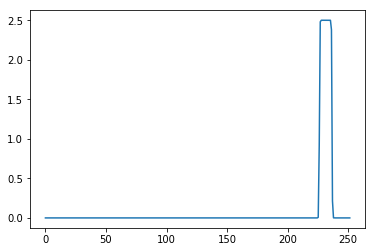

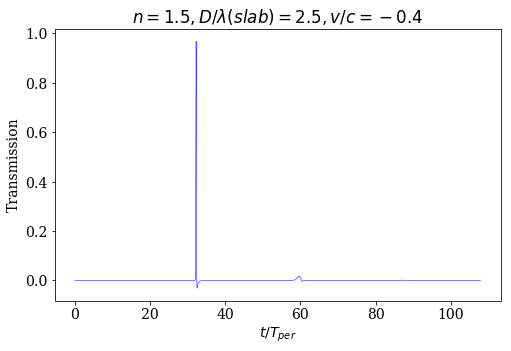

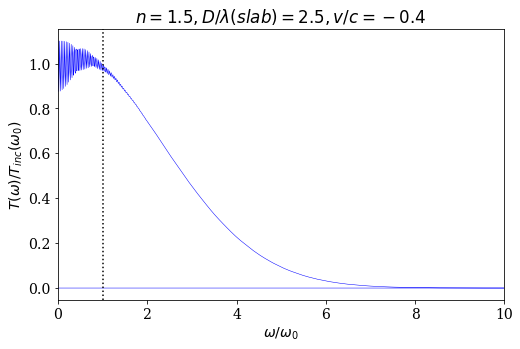

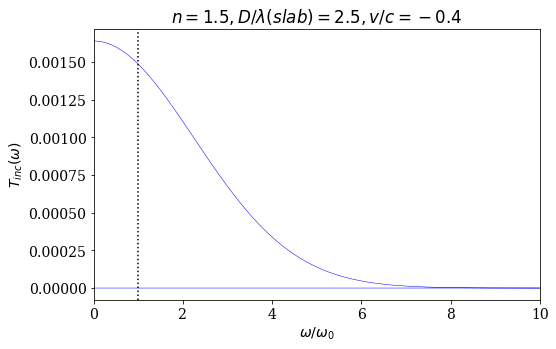

set_R_1d: True


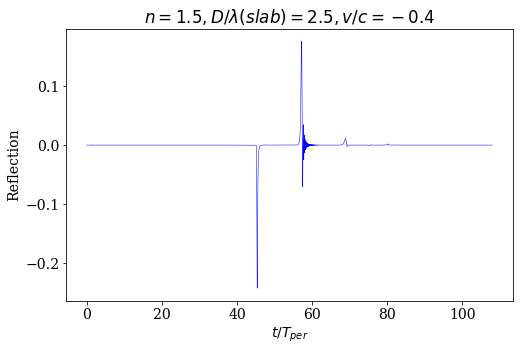

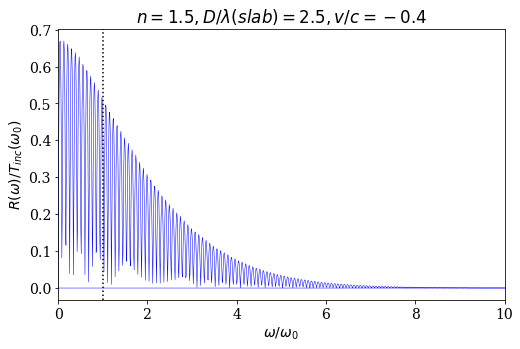

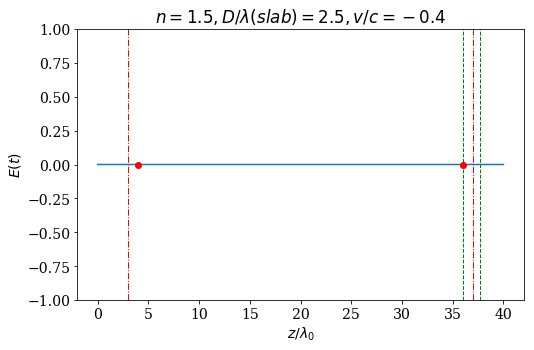

del_eps: 1.25 v_slab: -0.4
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:21
max(e_max): 1.00001233063
max(T): 0.97505051018
max(R): 0.241652785556
set_T_1d: True


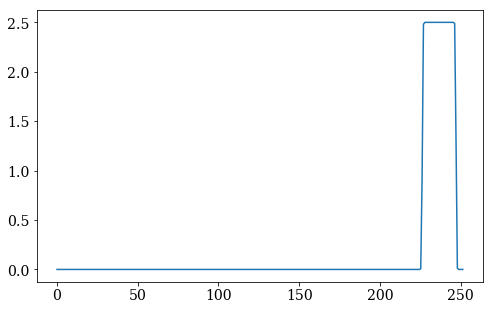

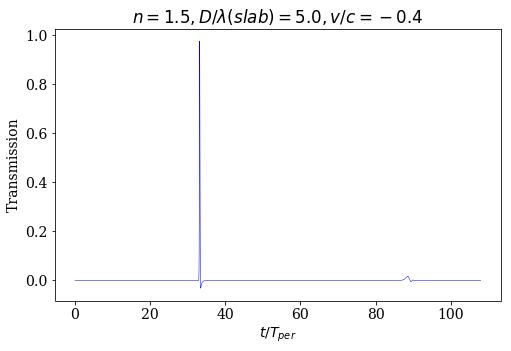

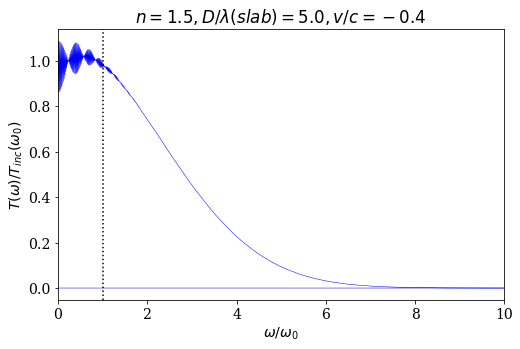

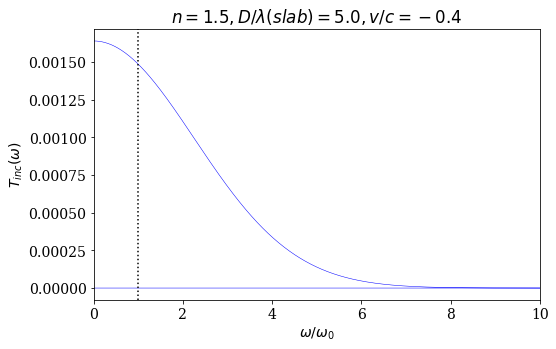

set_R_1d: True


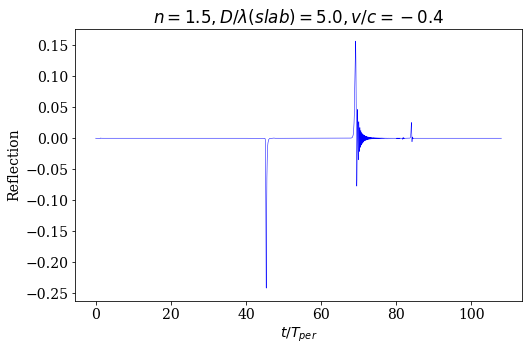

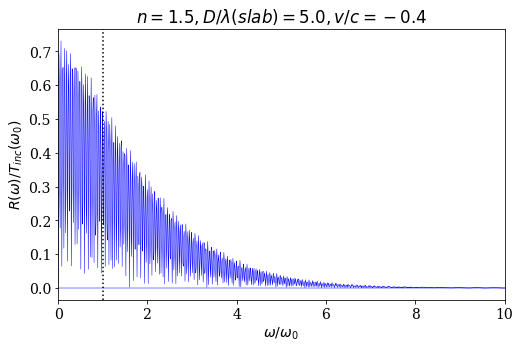

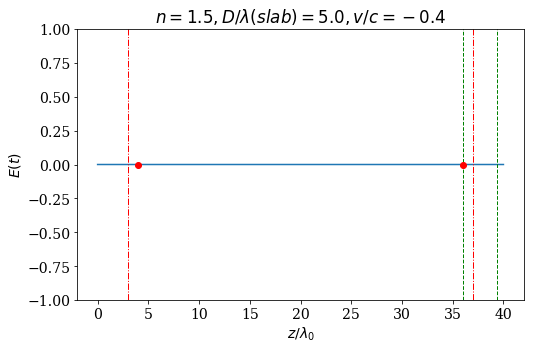

del_eps: 1.25 v_slab: -0.4
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 6:14
max(e_max): 1.00001233063
max(T): 0.970551537135
max(R): 0.339844474397
set_T_1d: True


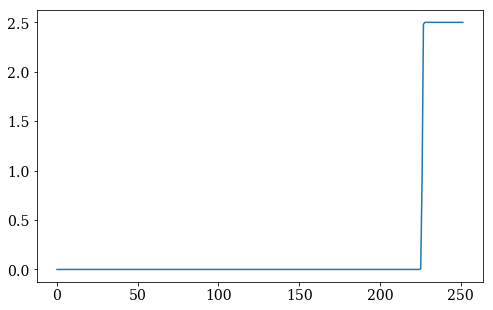

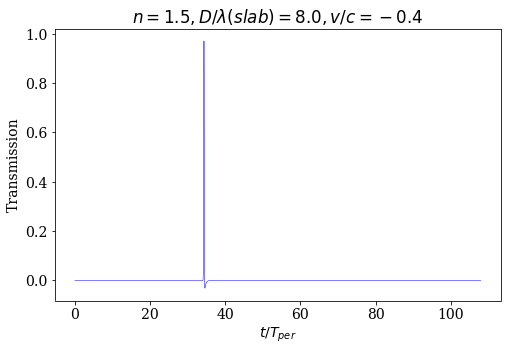

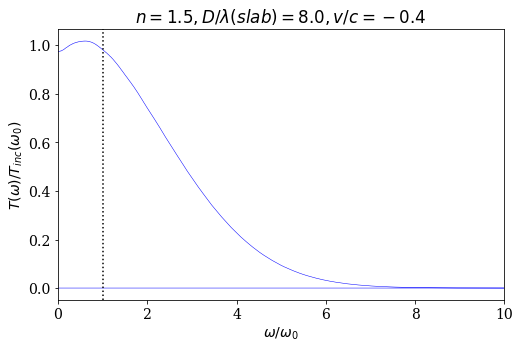

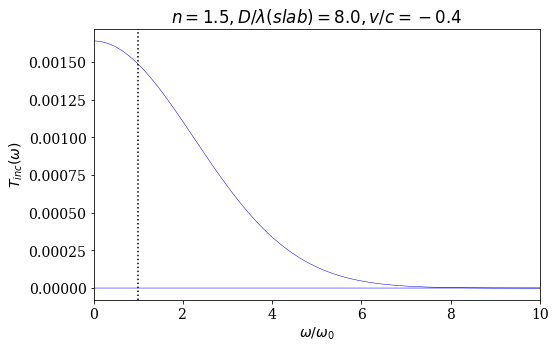

set_R_1d: True


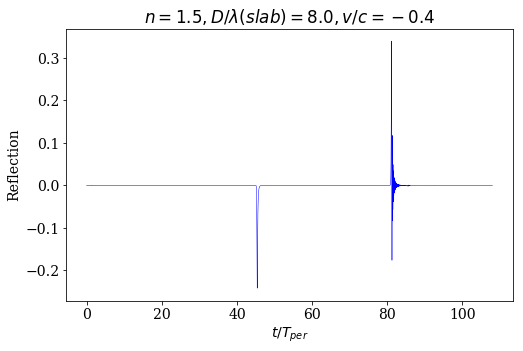

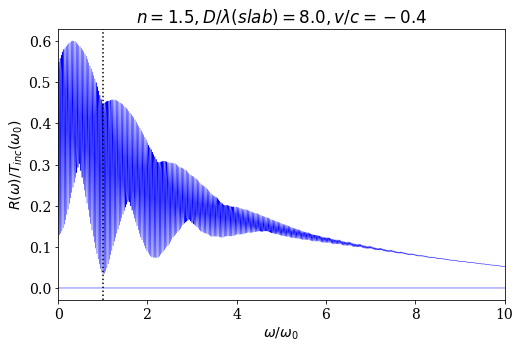

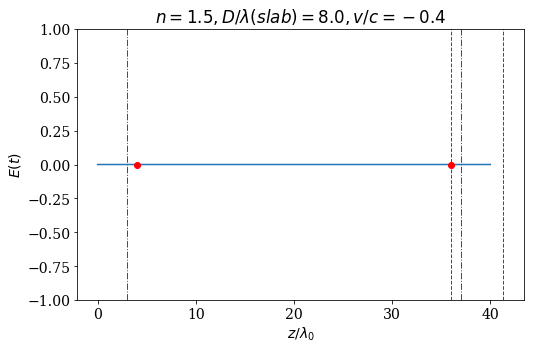

del_eps: 1.25 v_slab: -0.5
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:17
max(e_max): 2.03684986474
max(T): 0.982699722227
max(R): 1.29896024904
set_T_1d: True


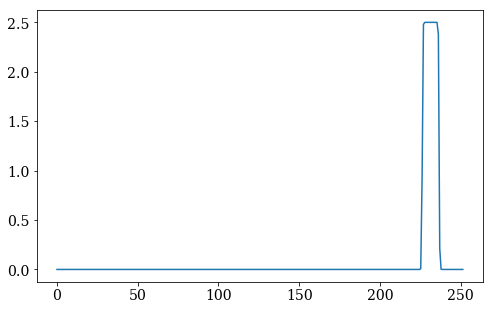

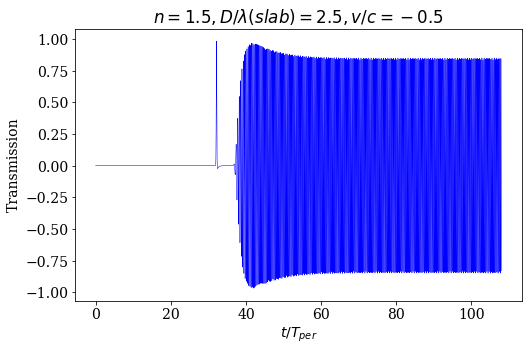

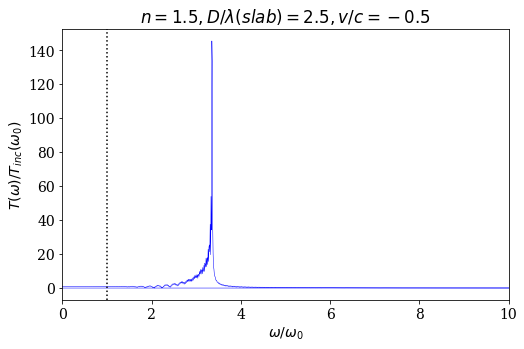

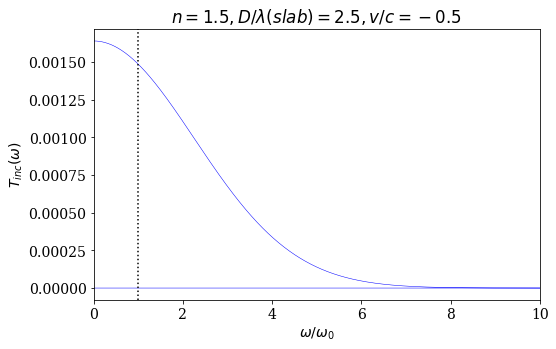

set_R_1d: True


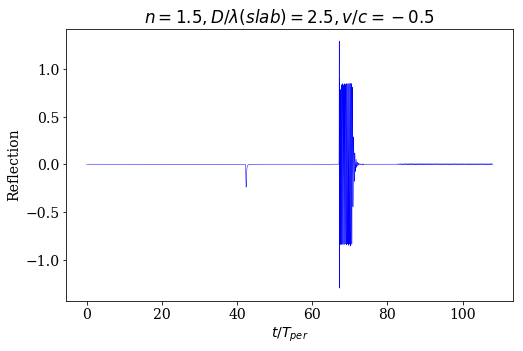

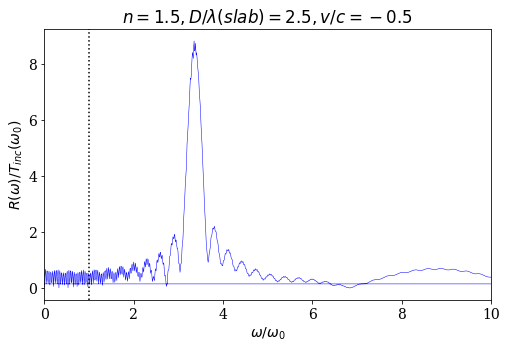

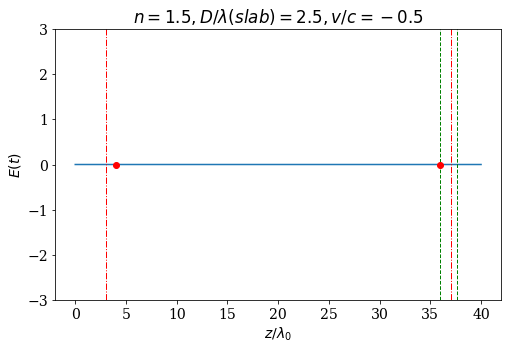

del_eps: 1.25 v_slab: -0.5
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:16
max(e_max): 2.0370454431
max(T): 0.977037583408
max(R): 1.60028660687
set_T_1d: True


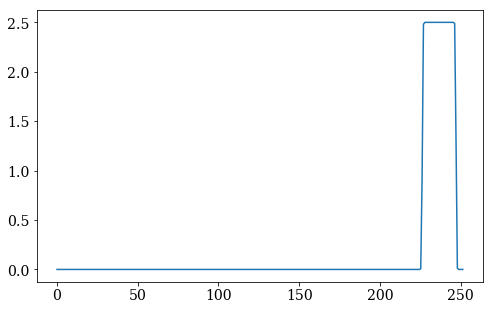

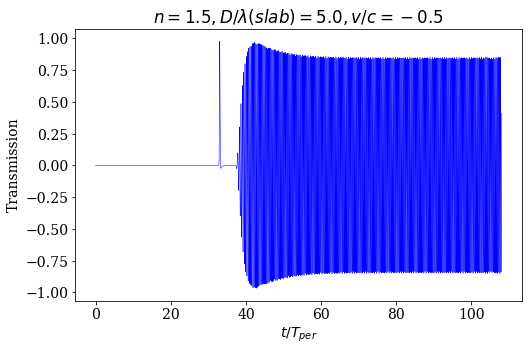

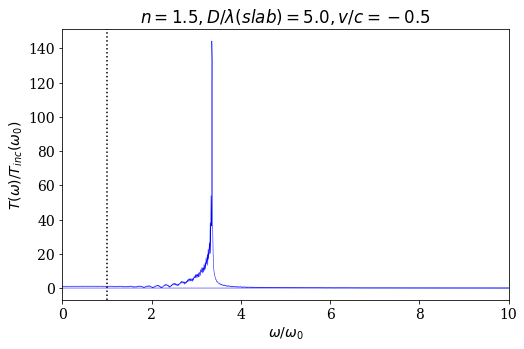

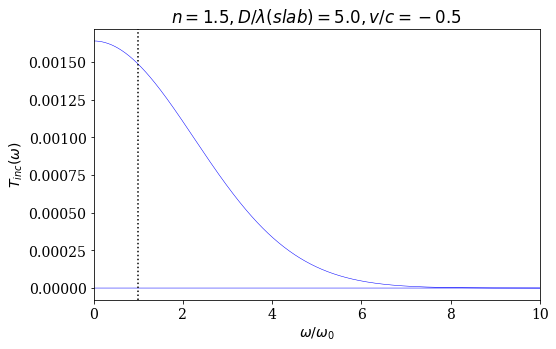

set_R_1d: True


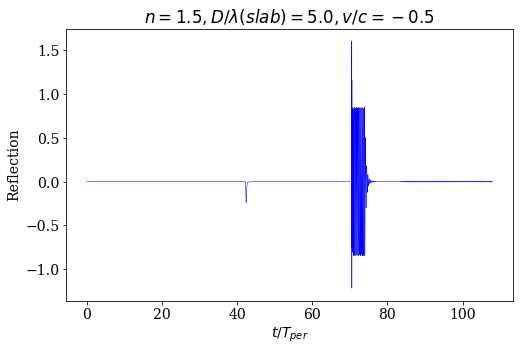

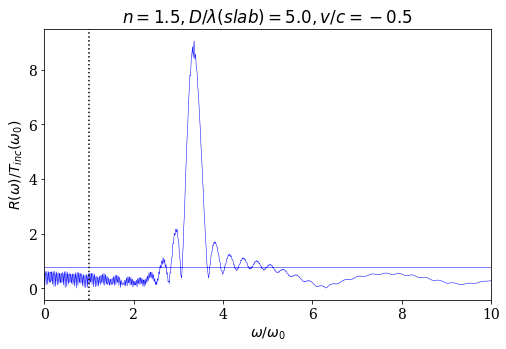

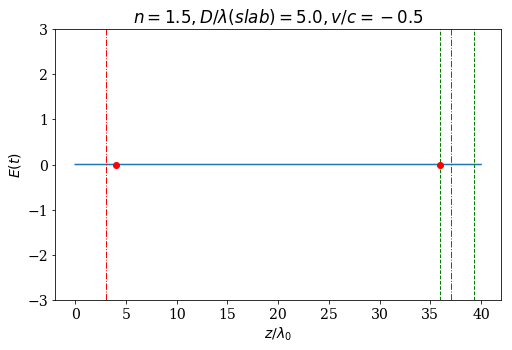

del_eps: 1.25 v_slab: -0.5
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 6:41
max(e_max): 2.03703640926
max(T): 0.97835880932
max(R): 1.74233260976
set_T_1d: True


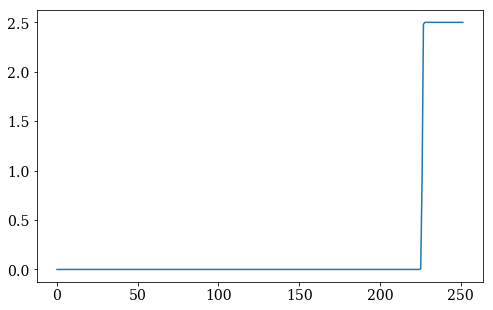

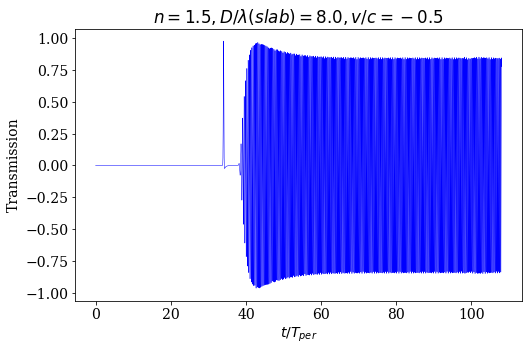

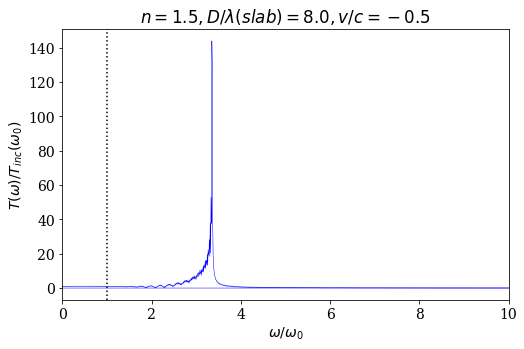

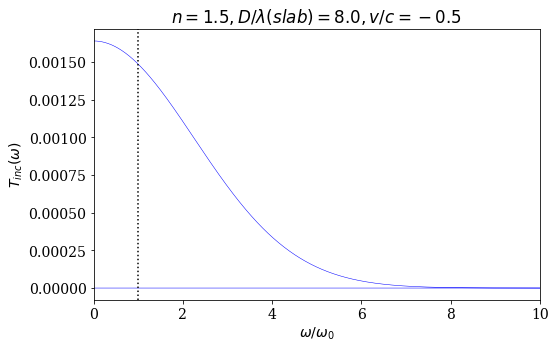

set_R_1d: True


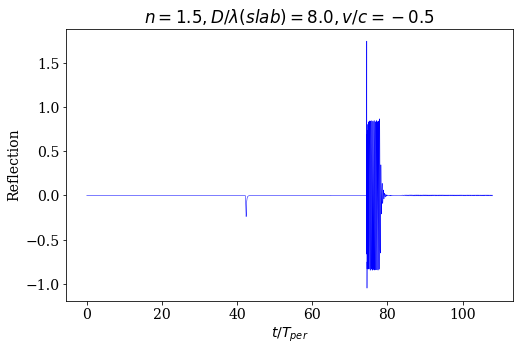

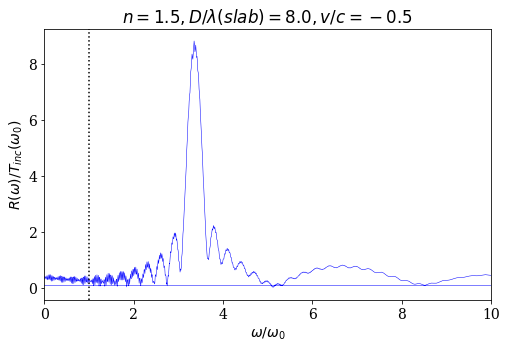

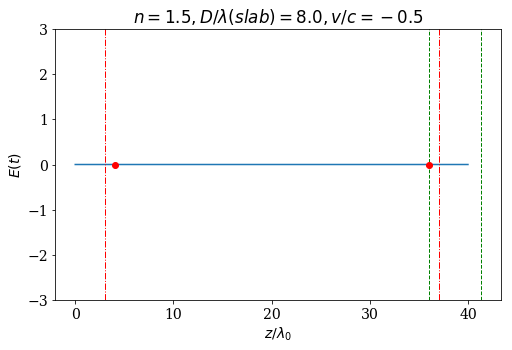

del_eps: 1.25 v_slab: -0.666
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:23
max(e_max): 7.25987625325
max(T): 4.75465251875
max(R): 2.72473927197
set_T_1d: True


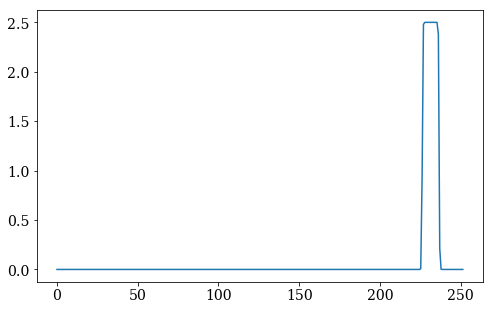

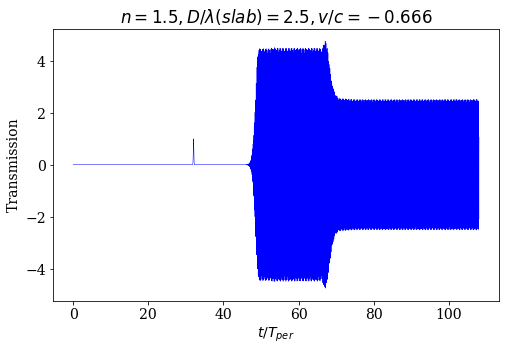

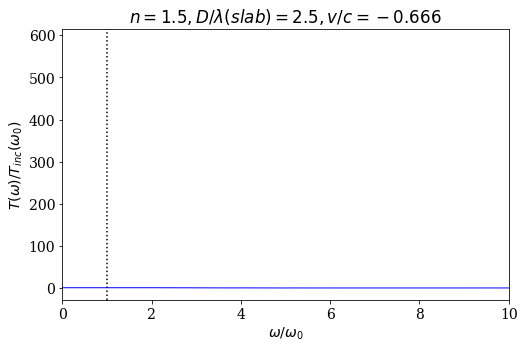

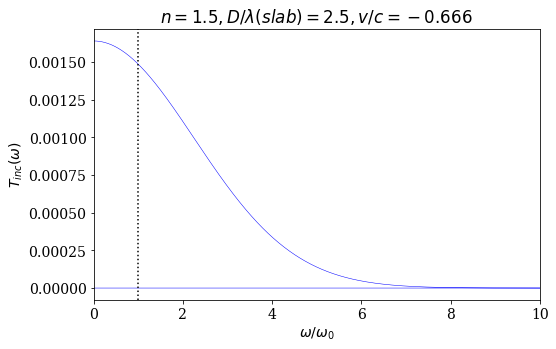

set_R_1d: True


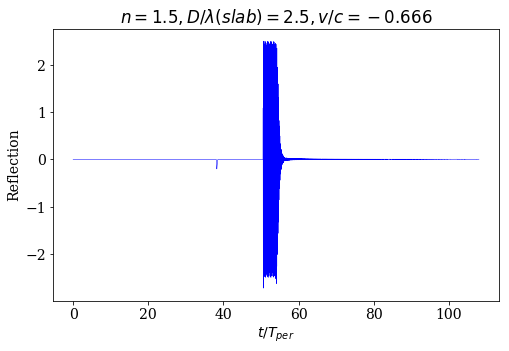

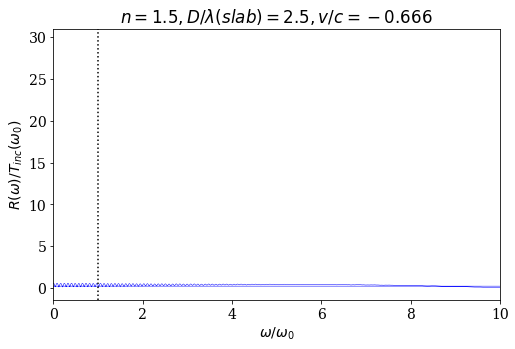

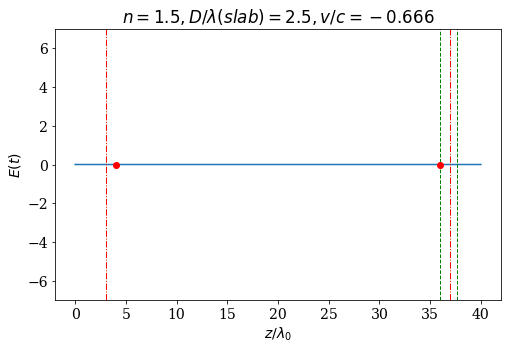

del_eps: 1.25 v_slab: -0.666
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:29
max(e_max): 7.25987530898
max(T): 4.79083009737
max(R): 2.62901759516
set_T_1d: True


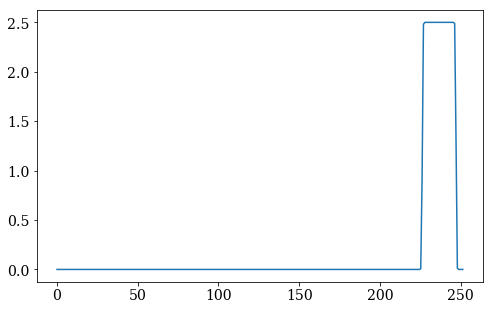

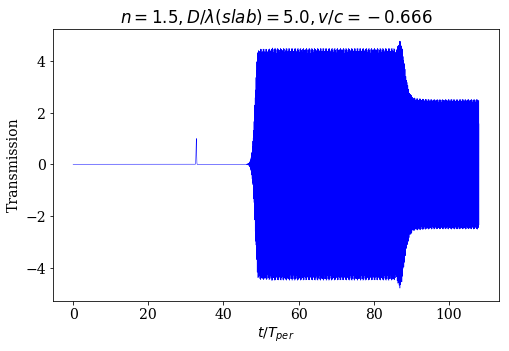

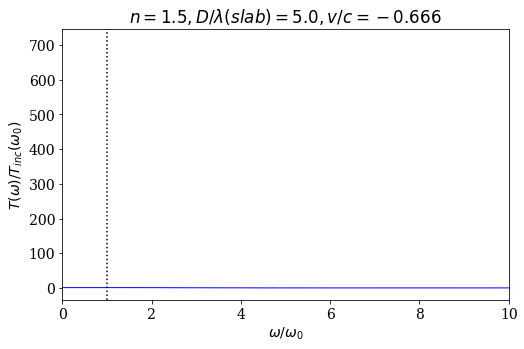

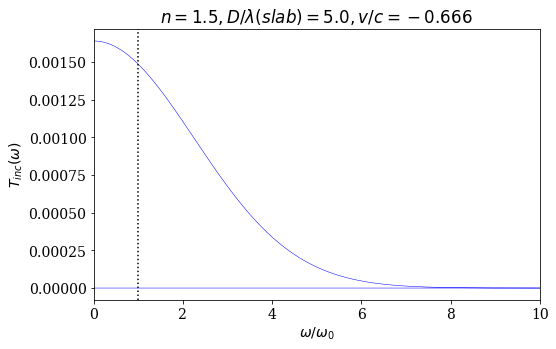

set_R_1d: True


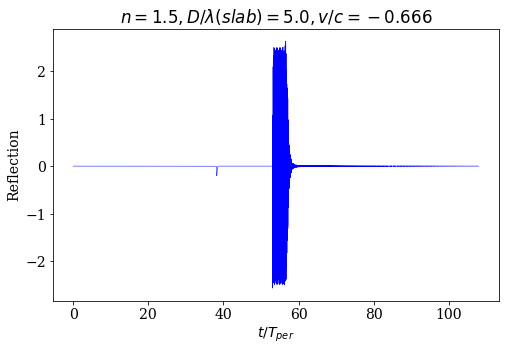

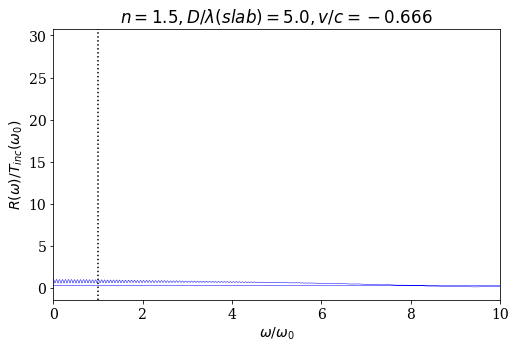

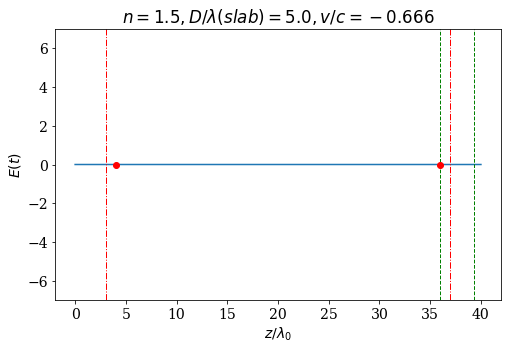

del_eps: 1.25 v_slab: -0.666
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:23
max(e_max): 7.26003844025
max(T): 4.49846697496
max(R): 2.58789488914
set_T_1d: True


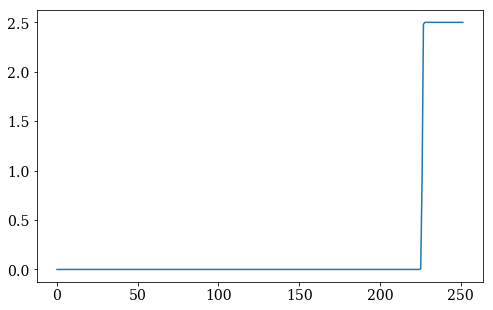

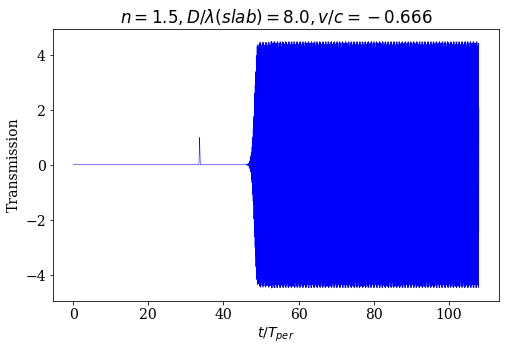

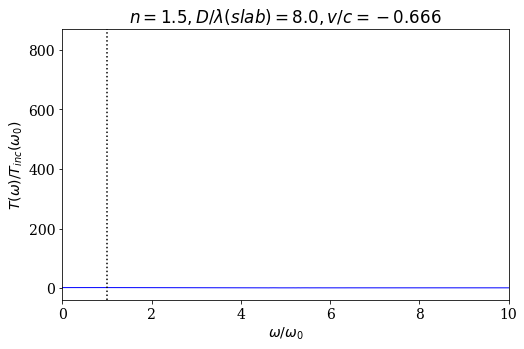

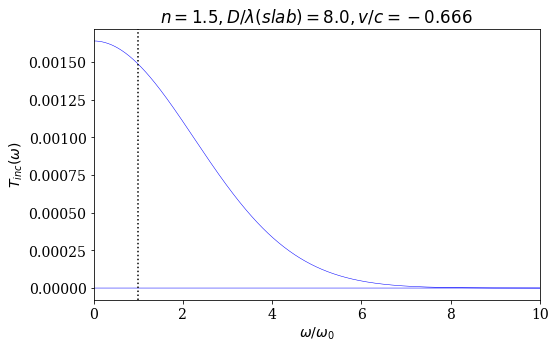

set_R_1d: True


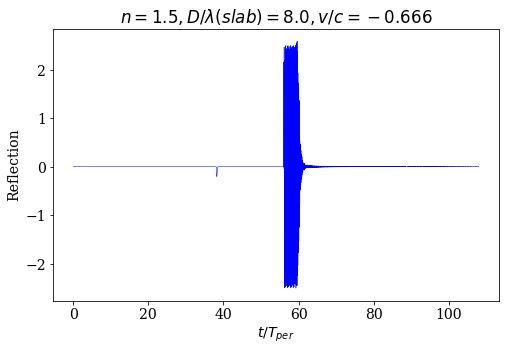

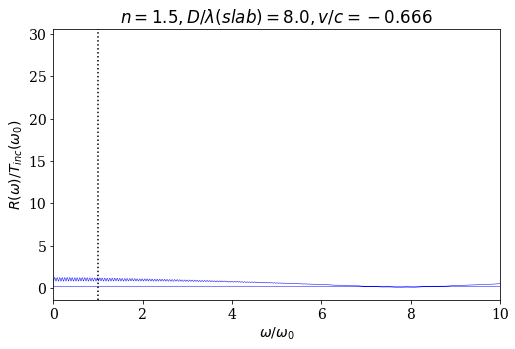

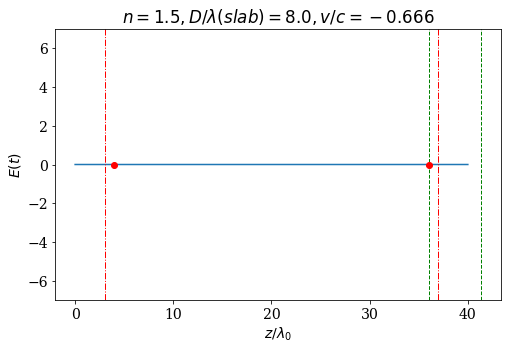

del_eps: 1.25 v_slab: -0.8
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 6:30
max(e_max): 11.2329995638
max(T): 1.00786300028
max(R): 2.10368454843
set_T_1d: True


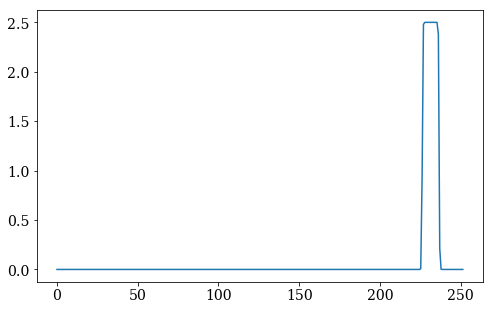

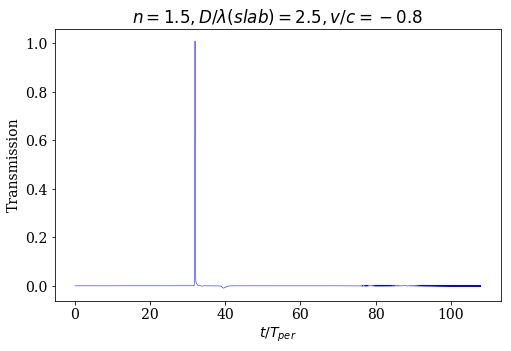

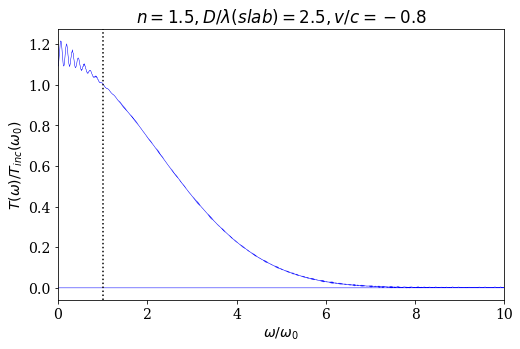

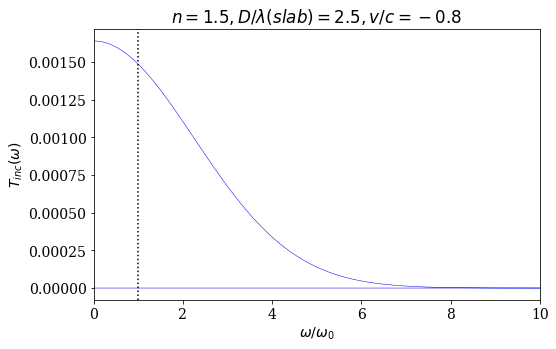

set_R_1d: True


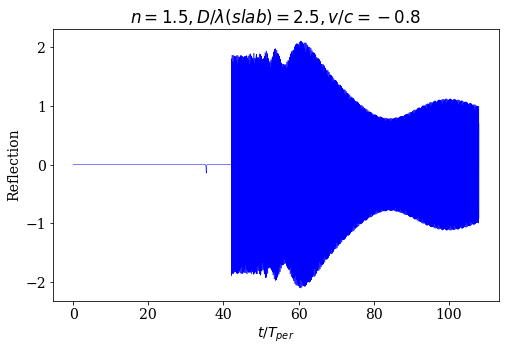

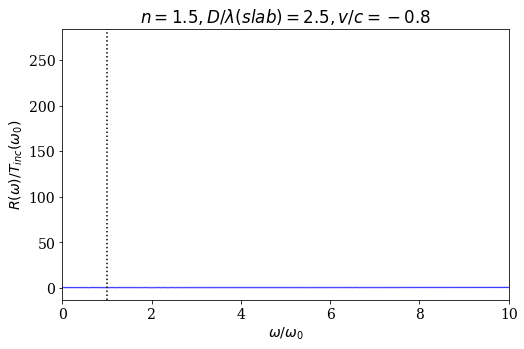

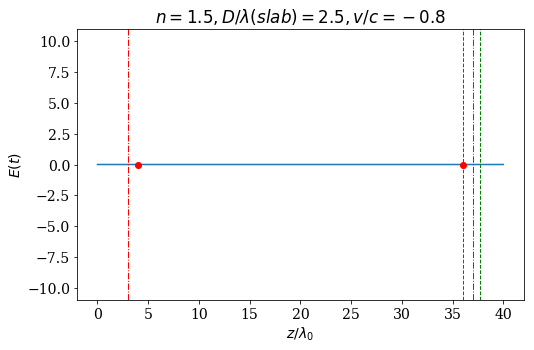

del_eps: 1.25 v_slab: -0.8
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 6:32
max(e_max): 11.2296017773
max(T): 1.00037420741
max(R): 2.10294597908
set_T_1d: True


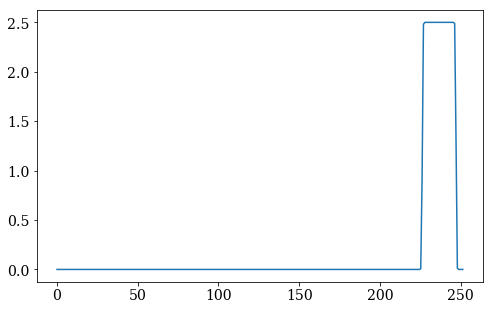

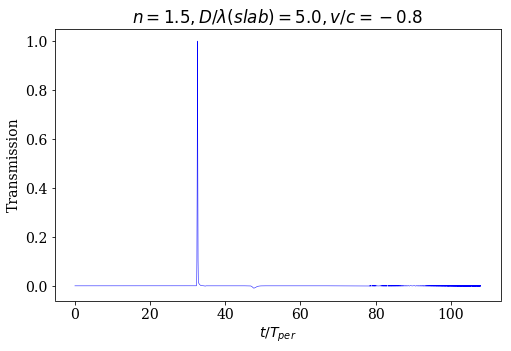

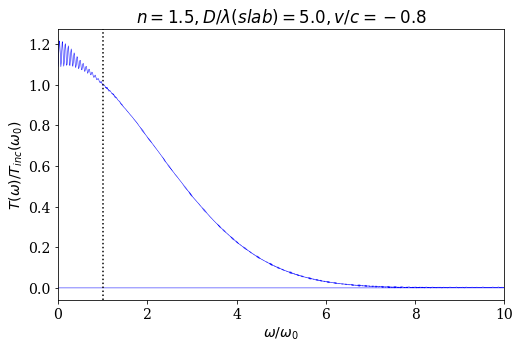

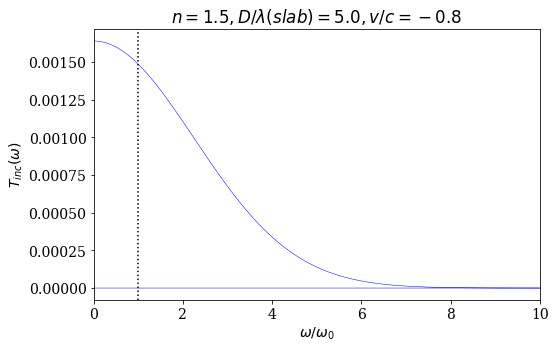

set_R_1d: True


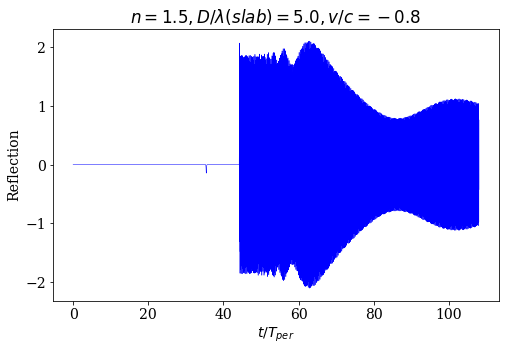

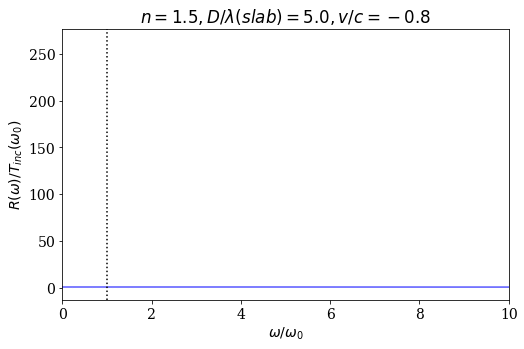

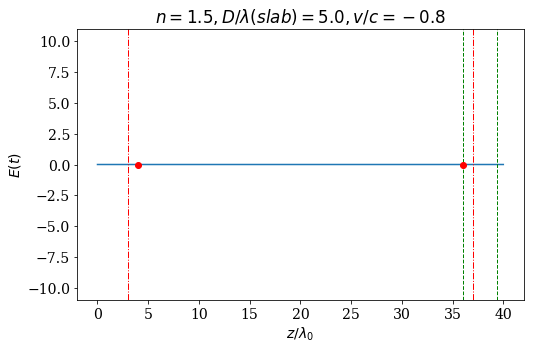

del_eps: 1.25 v_slab: -0.8
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 6:27
max(e_max): 11.2535269909
max(T): 1.00758715152
max(R): 2.10240247562
set_T_1d: True


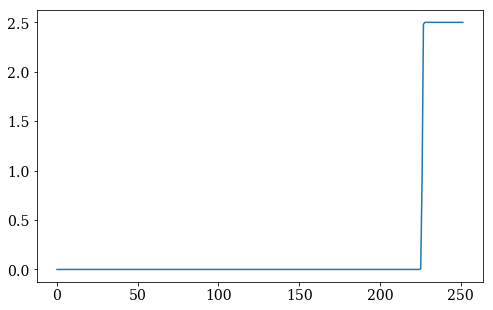

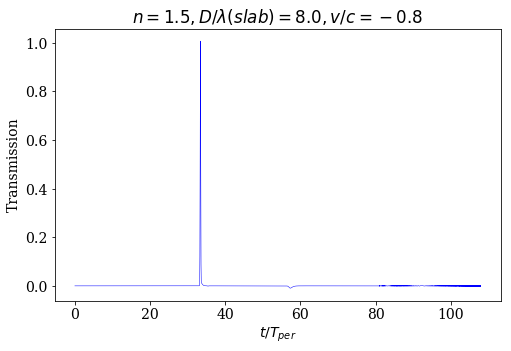

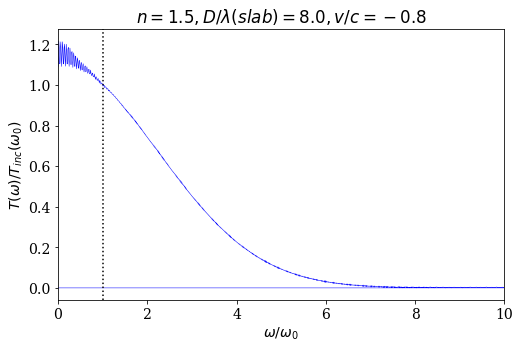

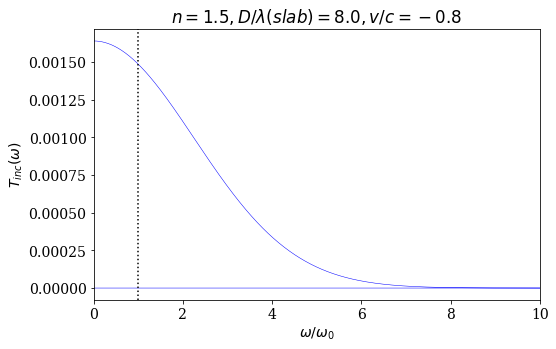

set_R_1d: True


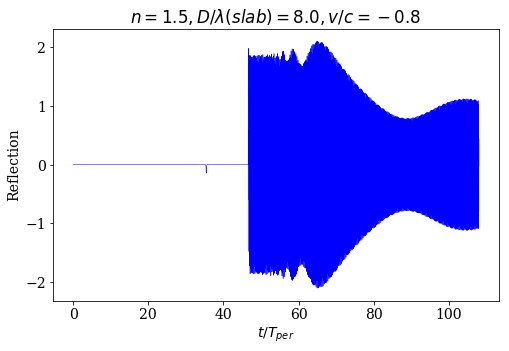

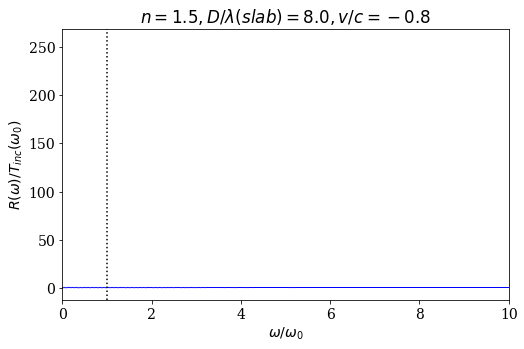

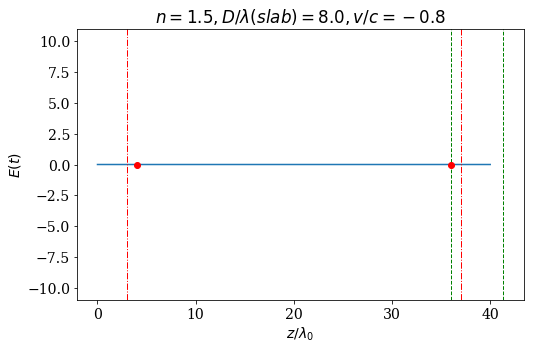

del_eps: 1.25 v_slab: -0.9
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:25
max(e_max): 14.8635546902
max(T): 1.00900081574
max(R): 8.84163118861
set_T_1d: True


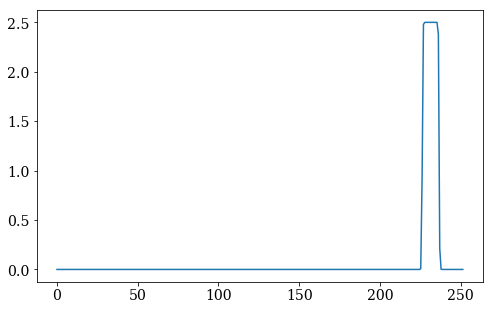

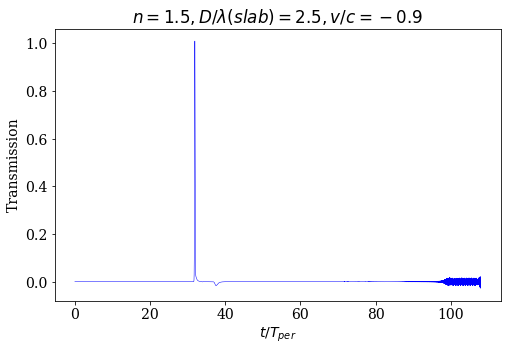

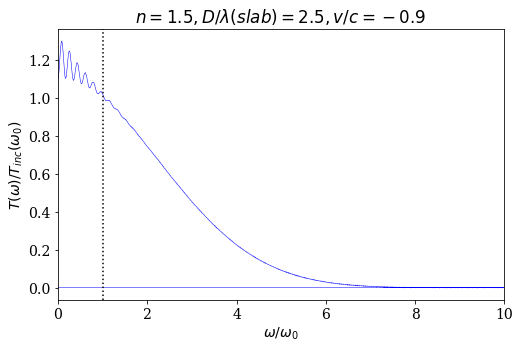

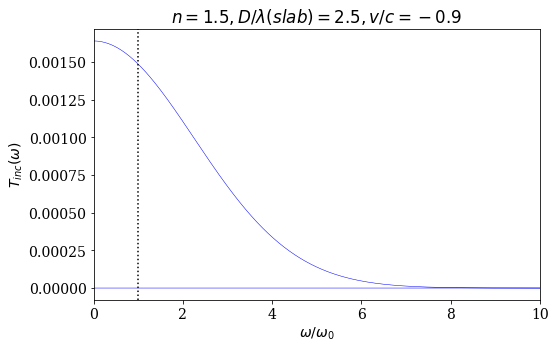

set_R_1d: True


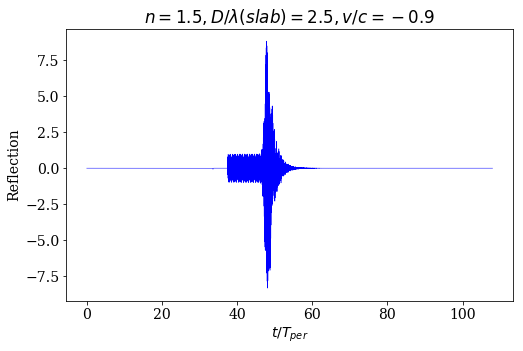

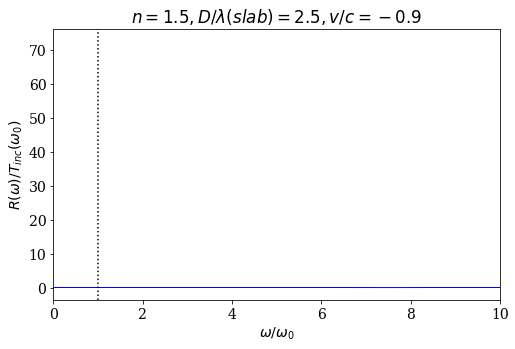

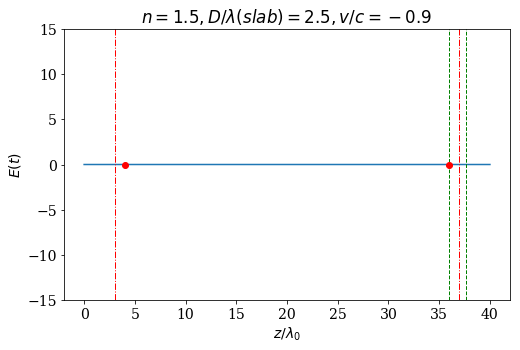

del_eps: 1.25 v_slab: -0.9
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:40
max(e_max): 13.9963688058
max(T): 1.01472590909
max(R): 8.59065980811
set_T_1d: True


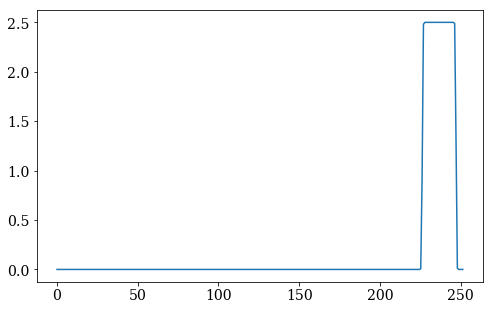

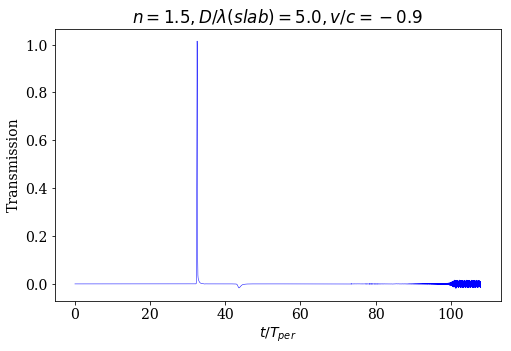

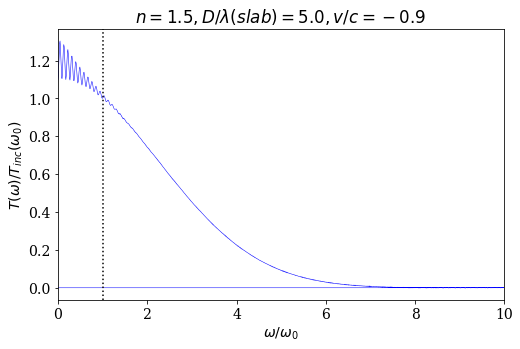

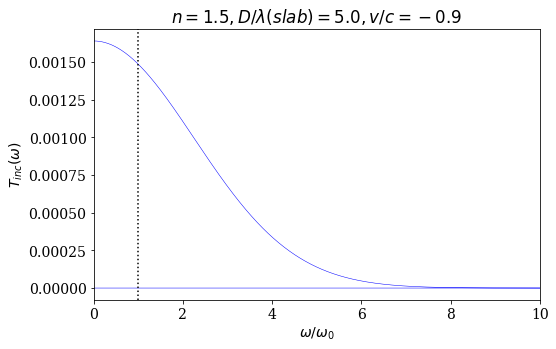

set_R_1d: True


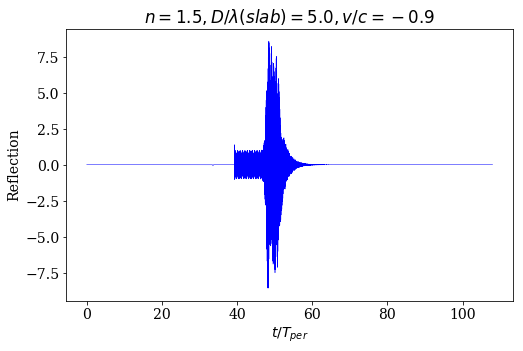

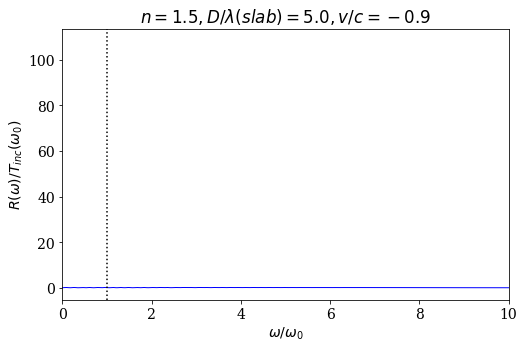

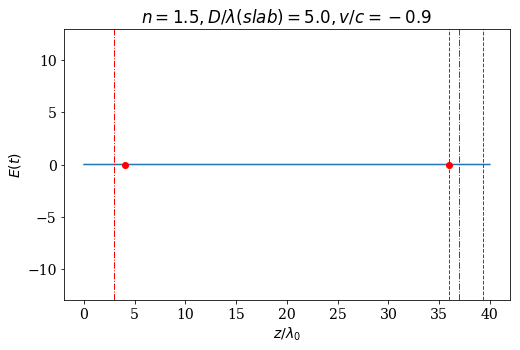

del_eps: 1.25 v_slab: -0.9
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 226.19467106] r_R_1d: [ 25.13274123]
simulation time: 5:20
max(e_max): 14.5686011613
max(T): 1.01547796888
max(R): 9.22771627883
set_T_1d: True


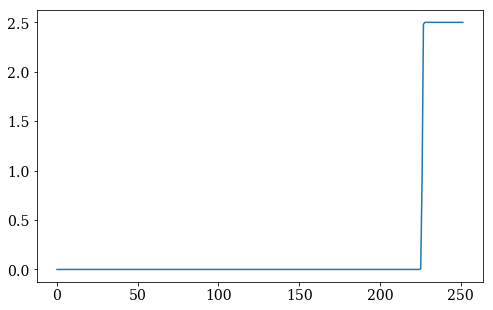

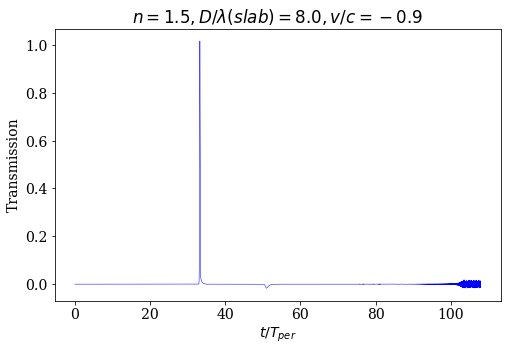

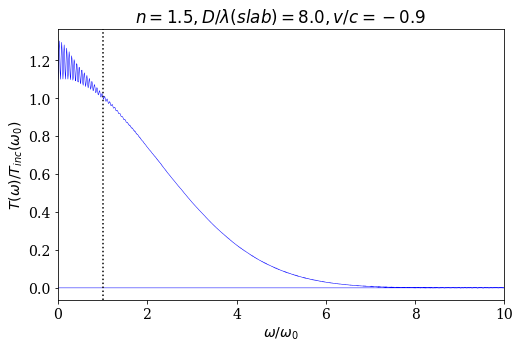

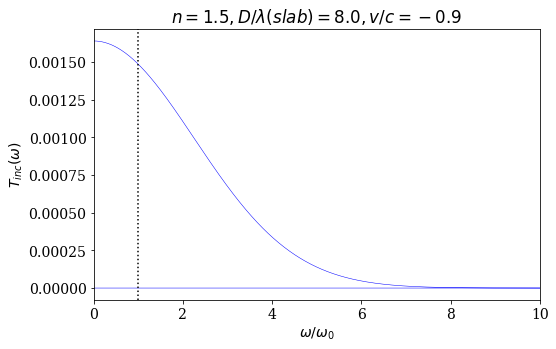

set_R_1d: True


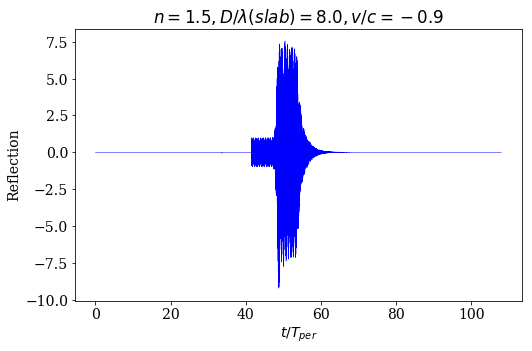

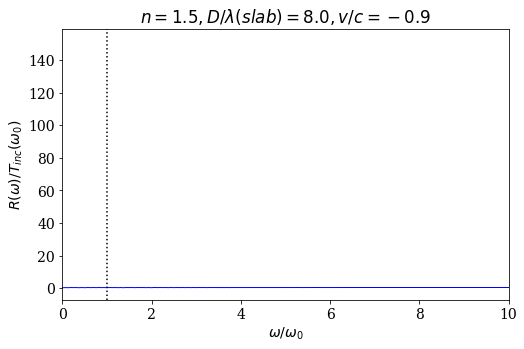

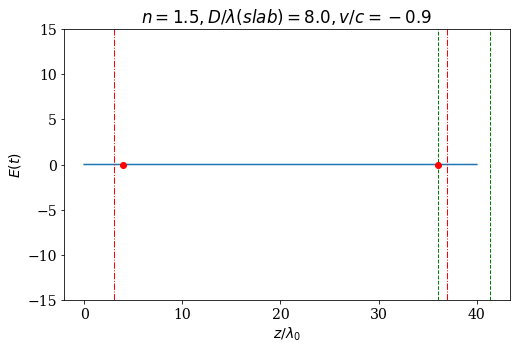

In [1]:
%pylab inline


from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

import os

e_max = 1.0

def run(_v_, _d_):
    global e_max
    _folder_ = "n=1.5,v={:.3},d={:.3}".format(_v_, _d_)
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'other', 'moving-slab', _folder_)
    file_ext = '.png'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


    n_dim = 1
    r0, r1, dr = [None]*3
    S = 0.9
    n_t = None
    save_every = 10
    source_at_right = False

    r_c = None
    r0_eps, r1_eps = None, None
    r0_deps, r1_deps = None, None
    a_eps, b_eps = None, None
    omega = 1.0 #2.0*np.pi
    s_pml = None
    d_pml = None
    set_pml = True
    is_t_var = True

    n = 1.0
    del_n = 0.5
    del_eps = (n+del_n)**2 - n**2

    L_0_air = 2.0*np.pi/(omega)
    L_0 = 2.0*np.pi/(omega*n)


    if n_dim==1:
        r0 = np.array([0.0])
        r1 = np.array([40.0*L_0])
        dr = np.array([L_0/500])
        S /= np.sqrt(1)
        n_t = 60000#2**18

        r_c = (r0+r1)/2.0
        a_eps, b_eps = n**2, 1.0
        w_eps = (r1-r0)/2
        r0_eps = r_c - w_eps/2.0
        r1_eps = r_c + w_eps/2.0

        d_pml = np.array([3.0*L_0])
        s_pml = np.array([1.0+2.5j/L_0])

        W_slab = r1 - r0 - 1.1*d_pml
        r0_deps = r_c - W_slab/2
        r1_deps = r_c + W_slab/2
    else:
        assert False

    dt = S*dr[0]*np.sqrt(min(a_eps+del_eps, b_eps))
    d_v = np.prod(dr)


    fdtd = FDTDSimulator()

    fdtd.SetSimulationBox(r0, r1, dr, dt)
    fdtd.save_every = save_every 

    d_x_ = np.zeros(n_dim)
    d_x_[0] = (r1[0]-r0[0])
    d_x_pml = np.zeros(n_dim)
    d_x_pml[0] = d_pml[0]


    ##----- sources

    T_per = 2.0*np.pi/omega
    T_0 = 0.1*T_per
    t0 = 3.0*T_0
    f_t = lambda t: -1.0*np.exp(-(t-t0)**2/T_0**2)#*np.sin(omega*(t-t0))
    f_t_dt = lambda t: f_t(t-dt/2)

    ## J
    r_j = r0 + d_pml + 2*L_0_air
    r_j -= r_j - int(r_j/dr[0])*dr[0]
    je_mag = 1.0/dr[0]
    src_dir = 'z'
    je_type = FVTypes.JePoint
    je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
    fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

    ## M
    r_m = r_j - dr[0]/2      
    jm_mag = -1.0/dr[0]/np.sqrt(b_eps)
    src_dir = 'y'
    jm_type = FVTypes.JmPoint
    jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
    fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


    eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':b_eps}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

    ##---- slab
    d_slab = _d_*L_0_air/(n+del_n)
    x_rise_slab = 0.05*L_0_air
    r0_slab = r1[0] - d_pml[0] - L_0_air
    v_slab = -_v_

    f_dslab = lambda x: (np.tanh(x/x_rise_slab) - np.tanh((x-d_slab)/x_rise_slab))

    _x = np.linspace(r0[0], r1[0], 300)
    plot(_x, f_dslab(_x-r0_slab))

    deps = None
    f_deps = None
    deps_out = []
    if is_t_var:
        print('del_eps:', del_eps, 'v_slab:', v_slab)
        a_deps = None
        if n_dim==1:
            a_deps = lambda r, t: del_eps*f_dslab((r-r0_slab) - v_slab*t)
        deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
        fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})

    if set_pml:
        pml_args = {'d_pml':d_pml, 's_pml':s_pml}
        fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

    set_Efields_entire_out = True
    set_eps_out = False
    set_j_out = False
    set_T_1d = True
    set_R_1d = True

    r_R_1d = r_j - (r_j-d_pml)/2.0
    r_T_1d = r1 - d_pml - L_0

    print('r0:', r0, 'r1:', r1)
    print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

    if set_Efields_entire_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
    if set_j_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
    if n_dim==1 and set_T_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
    if n_dim==1 and set_R_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})

    if is_t_var and set_eps_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


    fdtd.StepFields(n_t)
    n_saved = fdtd.n_saved

    ##---------------------------------------
    r_E, E_out_list = None, None
    x_E, y_E, z_E = [None]*3
    e_max = None
    if set_Efields_entire_out:
        r_E, E_out_list = fdtd.GetOutputs('E')
        if n_dim==3:
            x_E, y_E, z_E = r_E
        elif n_dim==2:
            x_E, y_E = r_E
        elif n_dim==1:
            x_E = r_E[0]
        e_max = [np.max(np.abs(e)) for e in E_out_list]
        print('max(e_max):', max(e_max))
        e_max = max(e_max)

    x_J, y_J, z_J = [None]*3
    j_max = None
    J_out_list = None
    if set_j_out:
        r_J, J_out_list = fdtd.GetOutputs('J')
        if n_dim==3:
            x_J, y_J, z_J = r_J
        elif n_dim==2:
            x_J, y_J = r_J
        elif n_dim==1:
            x_J = r_J[0]
        j_max = [np.max(np.abs(j)) for j in J_out_list]
        print('max(j_max):', max(j_max))
        j_max = max(j_max)



    x_deps, y_deps, z_deps = [None]*3
    deps_out_list = None
    deps_max = None
    if is_t_var and set_eps_out:
        r_deps, deps_out_list = fdtd.GetOutputs('Eps')
        if n_dim==3:
            x_deps, y_deps, z_deps = r_deps
        elif n_dim==2:
            x_deps, y_deps = r_deps
        elif n_dim==1:
            x_deps = r_deps[0]
        deps_max = [np.max(np.abs(de)) for de in deps_out_list]
        print('max(deps_max):', max(deps_max))
        deps_max = max(deps_max)


    x_T = None
    T_arr = None
    if n_dim==1 and set_T_1d:
        r_T, T_out_list = fdtd.GetOutputs('T')
        x_T = r_T[0]
        T_arr = np.array([t[0] for t in T_out_list])
        T_max = np.max(np.abs(T_arr))
        print('max(T):', T_max)

    x_R = None
    R_arr = None
    if n_dim==1 and set_R_1d:
        r_R, R_out_list = fdtd.GetOutputs('R')
        x_R = r_R[0]
        R_arr = np.array([t[0] for t in R_out_list])
        R_max = np.max(np.abs(R_arr))
        print('max(R):', R_max)


    #---------------------------------

    # Set up formatting for the movie files
    #Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
    #writer = Writer(fps=15, metadata=dict(artist='Me'))
    #writer = animation.FFMpegWriter()

    plt.rcParams["figure.figsize"] = (8, 5)

    plt_field = 'E'
    save_anim = True
    file_format = 'mp4'   ## 'gif' / 'mp4'

    logscale=False
    log_0 = np.log(e_max)-10

    use_subplots = False

    font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
    matplotlib.rc('font', **font)

    if set_T_1d:
        T_inc = f_t(np.arange(len(T_arr))*dt*save_every)
        T_inc_fft = np.fft.fft(T_inc)
        T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)


        print('set_T_1d:', set_T_1d)
        plt.figure()
        plt.plot(np.arange(len(T_arr))*dt*save_every/(2.0*np.pi/omega), T_arr, 'b', lw=0.5)
        plt.xlabel(r'$t/T_{per}$')
        plt.ylabel(r'Transmission')
        plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
        plt.savefig(os.path.join(dir_name, 'T' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

        np.savez(os.path.join(dir_name, 'T'), T_arr=T_arr)

        T_fft = np.fft.fft(T_arr)
        T_fft = np.abs(T_fft)/len(T_fft)
        freq = np.fft.fftfreq(T_fft.shape[-1], dt*save_every)

        ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
        plt.figure()
        plt.plot(2.0*np.pi*freq/omega, T_fft/T_inc_fft[ind], 'b', lw=0.5)
        #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
        plt.xlabel(r'$\omega/\omega_0$')
        plt.ylabel(r'$T(\omega)/T_{inc}(\omega_0)$')
        plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
        plt.xlim(0.0, 10)
        #plt.ylim([-10.0, 1.0])
        plt.axvline(x=1, color='k', linestyle=':')
        plt.savefig(os.path.join(dir_name, 'T-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

        plt.figure()
        plt.plot(2.0*np.pi*freq/omega, T_inc_fft, 'b', lw=0.5)
        #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
        plt.xlabel(r'$\omega/\omega_0$')
        plt.ylabel(r'$T_{inc}(\omega)$')
        plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
        plt.xlim(0.0, 10)
        #plt.ylim([-10.0, 1.0])
        plt.axvline(x=1, color='k', linestyle=':')
        plt.savefig(os.path.join(dir_name, 'T-inc-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

    if set_R_1d:
        print('set_R_1d:', set_R_1d)

        T_inc = f_t(np.arange(len(R_arr))*dt*save_every)
        T_inc_fft = np.fft.fft(T_inc)
        T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)

        plt.figure()
        plt.plot(np.arange(len(R_arr))*dt*save_every/(2.0*np.pi/omega), R_arr, 'b', lw=0.5)
        plt.xlabel(r'$t/T_{per}$')
        plt.ylabel(r'Reflection')
        plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
        plt.savefig(os.path.join(dir_name, 'R' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

        np.savez(os.path.join(dir_name, 'R'), R_arr=R_arr)

        R_fft = np.fft.fft(R_arr)
        R_fft = np.abs(R_fft)/len(R_fft)
        freq = np.fft.fftfreq(R_fft.shape[-1], dt*save_every)

        ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
        plt.figure()
        plt.plot(2.0*np.pi*freq/omega, R_fft/T_inc_fft[ind], 'b', lw=0.5)
        #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
        plt.xlabel(r'$\omega/\omega_0$')
        plt.ylabel(r'$R(\omega)/T_{inc}(\omega_0)$')
        plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
        plt.xlim(0.0, 10)
        #plt.ylim([-20.0, 20.0])
        plt.axvline(x=1, color='k', linestyle=':')
        plt.savefig(os.path.join(dir_name, 'R-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

    fig, axarr = None, None
    e_max = 1.0
    def animate_E(i):
        global e_max
        if not is_t_var:
            plt.clf()
            fig = plt.plot(x_E, E_out_list[i])
            axes = plt.gca()
            axes.set_ylim([-e_max, e_max])
            return fig
        else:
            if not use_subplots:
                plt.clf()
                fig = None
                if plt_field=='E':
                    fig = plt.plot(x_E/L_0_air, E_out_list[i])
                    ax = plt.gca()
                    e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/2.0)*2.0 + 1.0)
                    ax.set_ylim([-e_max, e_max])
                    #ax.set_ylim([-2.0, 2.0])
                    #ax.axes.get_xaxis().set_ticks([])
                    #ax.axes.get_yaxis().set_ticks([])
                elif plt_field=='Eps':
                    fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                    ax = plt.gca()
                    ax.set_ylim([-deps_max, deps_max])
                    ax.axes.get_xaxis().set_ticks([])
                #fig.set_tight_layout(True)
                plt.xlabel(r'$z/\lambda_0$')
                plt.ylabel(r'$E(t)$')
                plt.title('$n={}, D/\lambda(slab)={:.3}, v/c={:.3} $'.format(n+del_n, d_slab/(L_0_air/(n+del_n)), v_slab))
                ax = plt.gca()
                ax.set_adjustable('box-forced')
                #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)

                plt.axvline(x=(r0+d_pml)[0]/L_0_air, linewidth=1.0, linestyle='-.',color='r')
                plt.axvline(x=(r1-d_pml)[0]/L_0_air, linewidth=1.0, linestyle='-.',color='r')

                #plt.tight_layout(pad=0.0)

                _x_slab = r0_slab+v_slab*i*dt*save_every
                if _x_slab>0:
                    plt.axvline(x=_x_slab/L_0_air, linewidth=1.0, linestyle='--',color='g')
                    plt.axvline(x=(_x_slab+d_slab)/L_0_air, linewidth=1.0, linestyle='--',color='g')

                plt.plot([r_R_1d[0]/L_0_air], [0], marker='o', color='r')
                plt.plot([r_T_1d[0]/L_0_air], [0], marker='o', color='r')

                return fig
            else:
                plt.clf()
                fig, axarr = plt.subplots(2, sharex=True)
                axarr[0].plot(x_E, E_out_list[i])
                axarr[0].set_ylim([-e_max, e_max])
                axarr[1].plot(x_deps, deps_out_list[i], 'r')
                axarr[1].set_ylim([-deps_max, deps_max])
                return fig


    def animate_J(i):
        plt.clf()
        fig = plt.plot(x_J, J_out_list[i])
        axes = plt.gca()
        axes.set_ylim([-j_max, j_max])
        return fig

    anim = None
    if is_t_var and use_subplots:
        fig, axarr = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()

    if plt_field=='E' or plt_field=='Eps':
        anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
    elif plt_field=='J':
        anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
    else:
        raise ValuError()

    if save_anim:
        if file_format=='gif':
            anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
        elif file_format=='mp4':
            anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=30, dpi=100)
    plt.show()


    
for _v_ in [0.4, 0.5, 0.666, 0.8, 0.9]:
    for _d_ in [2.5, 5.0, 8.0]:
        run(_v_, _d_)
        
